In [1]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time
style.use('ggplot')

In [2]:
SIZE = 30 # 10 by 10 grid
HM_EPISODES = 55000
MOVE_PENALTY = 1
ENEMY_PENALTY = 300
FOOD_REWARD = 25
BORDER_PENALTY = 300

epsilon = 0.9
EPS_DECAY = 0.9998
SHOW_EVERY = 6000

start_q_table = None # or filename

LEARNING_RATE = 0.1
DISCOUNT = 0.95

PLAYER_N = 1
FOOD_N = 2
ENEMY_N = 3

d = {1: (255, 175, 0),
     2: (0, 255, 0),
     3: (0, 0, 255)}

In [3]:
class Player:
    def __init__(self):
        self.x = 0#np.random.randint(0, SIZE)
        self.y = np.random.randint(0, SIZE)
    
    def __str__(self):
        return f"{self.x}, {self.y}"
    
    def __sub__(self, other):
        return (self.x - other.x, self.y - other.y)
    
    def action(self, choice):
        if choice == 0:
            self.move(x=1, y=1)
        elif choice == 1:
            self.move(x=1, y=-1)
        elif choice == 2:
            self.move(x=1, y=0)

    
    def move(self, x=False, y=False):
        if not x:
            self.x += np.random.randint(0, 2)
        else:
            self.x += x
            
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y
            
        
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE - 1:
            self.x = SIZE - 1
            
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE - 1:
            self.y = SIZE - 1   

In [4]:
class Food:
    def __init__(self):
        self.x = 29
        self.y = 15
    
    def __str__(self):
        return f"{self.x}, {self.y}"
    
    def __sub__(self, other):
        return (self.x - other.x, self.y - other.y)
    
    def action(self, choice):
        if choice == 0:
            self.move(x=0, y=1)
        elif choice == 1:
            self.move(x=0, y=-1)

    
    def move(self, x=False, y=False):
        if not x:
            self.x += 0
        else:
            self.x += x
            
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y
            
        
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE - 1:
            self.x = SIZE - 1
            
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE - 1:
            self.y = SIZE - 1   

In [5]:
if start_q_table is None:
    # El espacio de estados es el delta de distancia entre comida y el segundo es al enemigo
    # 4 valores para cada acción por cada estado
    q_table = {}
    for x1 in range(-SIZE+1, SIZE):
        for y1 in range(-SIZE+1, SIZE):
                    q_table[((x1, y1))] = [np.random.uniform(-5,0) for i in range(3)]
else:
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f) 

on # 0, epsilon: 0.9
6000 ep mean nan


C:\Users\Germa\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Germa\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


on # 6000, epsilon: 0.27104225936046566
6000 ep mean -7070.3
on # 12000, epsilon: 0.08162656262136181
6000 ep mean -2416.0
on # 18000, epsilon: 0.024582497729691496
6000 ep mean -1315.6
on # 24000, epsilon: 0.0074032174726434705
6000 ep mean -1015.85
on # 30000, epsilon: 0.0022295386559135037
6000 ep mean -766.05
on # 36000, epsilon: 0.0006714435495892111
6000 ep mean -728.05
on # 42000, epsilon: 0.00020221064079296736
6000 ep mean -672.65
on # 48000, epsilon: 6.0897365496947774e-05
6000 ep mean -684.45
on # 54000, epsilon: 1.8339732814880746e-05
6000 ep mean -633.95


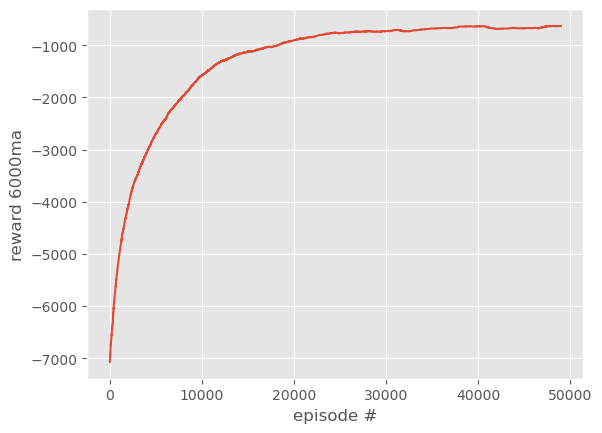

In [6]:
episode_rewards = []
for episode in range(HM_EPISODES):
    player = Player()
    food = Food()
  
    
    if episode % SHOW_EVERY == 0:
        print(f"on # {episode}, epsilon: {epsilon}")
        print(f"{SHOW_EVERY} ep mean {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False
        
    
    episode_reward = 0
    # Número de steps
    for i in range(200):
        obs = (player-food)
        if np.random.random() > epsilon:
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0, 3)
        
        player.action(action)
        
        
        #enemy.move()
        food.move()

        if player.x == food.x and player.y == food.y:
            reward = FOOD_REWARD
        elif player.x == 29 and player.y != food.y:
            reward = -BORDER_PENALTY
        else:
            reward = -MOVE_PENALTY
        
        
        new_obs = (player - food)
        max_future_q = np.max(q_table[new_obs])
        current_q = q_table[obs][action]
        
        
        
        # Cálculo del nuevo q
        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        
        q_table[obs][action] = new_q
        
        
        if show:
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)
            env[food.y][food.x] = d[FOOD_N]
            env[player.y][player.x] = d[PLAYER_N]

            
            
            img = Image.fromarray(env, "RGB")
            img = img.resize((300,300))
            cv2.imshow("", np.array(img))
            
            # Simulation ended (pause)
            if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
                if cv2.waitKey(300) & 0xFF == ord("q"):
                    break
            else:
                if cv2.waitKey(100) & 0xFF == ord("q"):
                    break
            
            
        episode_reward += reward
        if reward == FOOD_REWARD:
            break
            
            
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,)) / SHOW_EVERY, mode = "valid")
            
plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()

with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)     

In [ ]:
action

In [ ]:
obs

In [ ]:
q_table[obs][2]